## Predicting Metallic Glasses
by Brenna Gibbons

adapted from a CS229 class project with Cooper Elsworth

-----------------------



In [92]:
# housekeeping
import pandas as pd
import numpy as np
import itertools
import csv
import itertools
import sys
# for ML
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn import preprocessing
# for plotting
import ternary
from bisect import bisect_left
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

### Data Processing
This project worked with two sets of data, one sparse (historical data) and one dense (modern high-throughput data). In each case, the data consists of a composition and a classifier.

In [7]:
filename = 'TFdataforCitrination_LBformat.csv'
data = pd.read_csv(filename,header=0,skiprows = [1])
data.head()

,Formula,ac
0,Co0.378885483Cr0.253858325Zr0.367256192,amorphous
1,Co0.445143559Cr0.216190121Zr0.33866632,amorphous
2,Co0.433898818Cr0.22555395Zr0.340547232,amorphous
3,Co0.422599671Cr0.235405133Zr0.341995196,amorphous
4,Co0.411254217Cr0.24576858Zr0.342977203,amorphous


In [9]:
orderDict = {"amorphous":'AM',"amorphous-crystalline":'AC',"crystalline":'CR'}
ternaries = set()

alllines = []

for index, row in data.iterrows():
    order = row['ac']
    formula = row['Formula']

    splitf = ["".join(x) for _, x in itertools.groupby(formula, key=str.isalpha)]

    comp = []
    elems = []
    total = 0
    for i in range(0, len(splitf)-1,2):
        el = splitf[i]
        st = round(float(splitf[i+1]) * 100,7)
        total += st
        elems.append([el,st])

    # sort list so alphabetical by element
    elems.sort(key=lambda x: x[0])
    formula = ''.join([''.join([x[0],str(x[1])]) for x in elems])

    ternary = [x[0] for x in elems]
    ternaries.add(''.join(ternary))

    f = ''.join([''.join([x[0],str(round(x[1],3))]) for x in elems])

    alllines.append(f+' '+orderDict[order]+'\n')
    
print("{} unique ternaries: {}".format(len(ternaries), ternaries))
print('\n')
print("Example line: \n{}".format(alllines[0]))

with open('all_hitp.txt','w') as f:
    f.write('comp gfa{AM,AC,CR}\n')
    for line in alllines:
        f.write(line)

9 unique ternaries: {'CoTiZr', 'CrTiZr', 'CoVZr', 'NbNiTi', 'CoCrNi', 'CoCrZr', 'NiSiTi', 'CoFeZr', 'FeNbTi'}


Example line: 
Co37.889Cr25.386Zr36.726 AM



=======================
### Data Visualization

In [90]:
def plot_ternary_data(filename,outputname, exp=True):
    data = []

    with open(filename,'r') as f:
        reader = csv.reader(f)
        for row in reader:
            r = row[0].split(' ')
            r[1] = float(r[1])*100
            r[3] = float(r[3])*100
            r[5] = float(r[5])*100
            r[6] = float(r[6])
            r[1] = float("{0:.1f}".format(r[1]))
            r[3] = float("{0:.1f}".format(r[3]))
            r[5] = float("{0:.1f}".format(r[5]))
            data.append(r)

    am = []
    cr = []
    
    # order: bottom, right, left
    for d in data:    
        x = d[1]
        y = d[3]
        z = d[5]
        if d[6] == 0:
            cr.append([x,y,z])
        else:
            am.append([x,y,z])
    
    d2 = {}
    for row in data:
        d2[(row[1],row[3],row[5])] = 1-row[6]
            
    xname = data[0][0]  
    yname = data[0][2]
    zname = data[0][4]
            
    scale = 100
    fontsize = 15
    figure, tax = ternary.figure(scale=scale)
    tax.boundary(linewidth=2.0)
    tax.gridlines(multiple=10,color="grey")
    tax.left_axis_label(zname, fontsize=fontsize)
    tax.right_axis_label(yname, fontsize=fontsize)
    tax.bottom_axis_label(xname, fontsize=fontsize)

    if exp:
        tax.scatter(am,marker='o', edgecolor='black', linewidth='1', facecolor='red',label = "AM = amorphous")
        # tax.scatter(ac,marker='s',edgecolor='black', linewidth='1',facecolor='green',label="AC")
        tax.scatter(cr,marker='o', edgecolor='black', linewidth='1', facecolor='blue',label = "CR = crystalline")
        tax.legend(fontsize=fontsize)
    else:
#         tax.heatmapf(generate_heatmap_values,style='triangular',
#              cmap = "bwr",vmin=0, vmax=1
#             )
        tax.heatmap(d2,scale=100,style='triangular',
             cmap = "bwr",vmin=0, vmax=1
            )

    # set up ticks
    if exp:
        tax.clear_matplotlib_ticks()
        figure.set_size_inches(8,8)
    else:
        tax.ticks(axis='lbr', linewidth=1, multiple=10)
        figure.set_size_inches(10,8)

    figure.savefig(outputname,transparent=True,dpi=200)

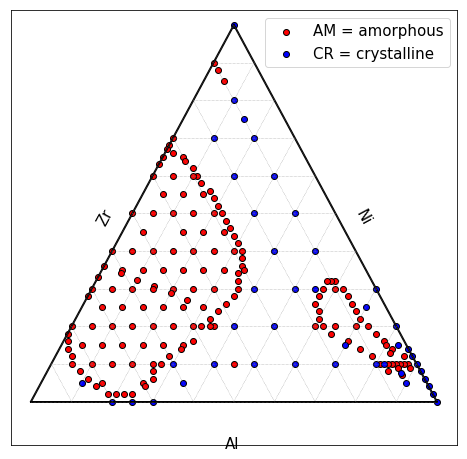

In [75]:
plot_ternary_data('data/alnizr_exp.csv','plots/alnizr_exp.png',True)

=======================
### Data Featurization
Use Magpie, developed by the Wolverton group at Northwestern, to featurize the data based on the composition


In [13]:
def load_prep_data(filename,allfeatures):
    ######   Load data to predict from ../data/comp_and_features.csv   ######
    mydata = pd.read_csv(filename,header=0)
    del mydata['gfa_measured'] #remove feature that is equivalent to class
    myfeatures = mydata.columns[:-2]
    myend_of_elem = np.where(myfeatures.values=='NComp')[0][0]
    
    # Extract list of elements (elements)
    myelements = myfeatures[0:myend_of_elem]
    mydata['is_train'] = 0
    mydata['ternary_name'] = mydata.apply(lambda row: ternaryName(row,myelements),axis=1)
    # populate elements that this data didn't have
    
    allmyFeatures = list(mydata)
    missing_features = [x for x in allfeatures if x not in allmyFeatures]
    for f in missing_features:
        mydata[f] = 0
    mydata[not_elements] = preprocessing.scale(mydata[not_elements])
    
    return mydata

In [22]:
def ternaryName(row,elements):
    composition = row[elements].to_numpy().nonzero()[0]
    return '-'.join(sorted(elements[composition].values))

In [20]:
######   Load low-throughput data from ../data/comp_and_features.csv   ######
data = pd.read_csv('comp_and_features.csv',header=0)
del data['gfa_measured'] #remove feature that is equivalent to class
data.head()

,Be,B,C,Mg,Al,Si,P,Ca,Sc,Ti,...,min_SpaceGroupNumber,most_SpaceGroupNumber,frac_sValence,frac_pValence,frac_dValence,frac_fValence,CanFormIonic,MaxIonicChar,MeanIonicChar,Class
0,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,225.0,225.0,0.667,0.3330,0.000,0.0,0.0,0.00000,0.000000,1.0
1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,194.0,194.0,0.222,0.0000,0.778,0.0,0.0,0.00000,0.000000,1.0
2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,225.0,225.0,0.200,0.0000,0.800,0.0,0.0,0.00000,0.000000,1.0
3,0.0,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,166.0,229.0,0.193,0.0175,0.789,0.0,0.0,0.00359,0.000647,1.0
4,0.0,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,166.0,229.0,0.207,0.0270,0.766,0.0,0.0,0.00359,0.000916,1.0


In [26]:
# Extract list of feature names (features)
features = data.columns[:-2]
end_of_elem = np.where(features.values=='NComp')[0][0]

# Extract list of elements (elements)
elements = features[0:end_of_elem]
not_elements = features[end_of_elem:]

# Normalize data to have zero-mean and unit variance
data[not_elements] = preprocessing.scale(data[not_elements])

# Extract list of ternaries (ternaries)
data['ternary_name'] = data.apply(lambda row: ternaryName(row,elements),axis=1)
ternaries = np.unique(data['ternary_name'].values,return_counts=True)

print(ternaries[0][0:5])

['Ag-Al-La' 'Ag-Al-Mg' 'Ag-Ce-Cu' 'Ag-Cu' 'Ag-Cu-Fe']


=======================
### Set up for models

In [31]:
######   Tuning parameters   ######
train_size = .8

### Splitting the test/train data
Random split

<img src="data/cluster1.png" width="400" align="left">

<br><br><br><br><br><br><br><br><br><br><br><br>

Ternary split

<img src="data/cluster2.png" width="400" align="left">

In [123]:
def split_test_train(data, ternaries, percentTest, splitHTP=True):

    train_size = 1.0-percentTest
    #for j in range(100):
    # Split data into training and test sets, based on train_size parameter
    tern_shuf = list(zip(ternaries[0],ternaries[1]))
    np.random.shuffle(tern_shuf)

    # Move ternaries of interest to test set
    if splitHTP:
        temp = [tern_shuf.index(item) for item in tern_shuf if
                (item[0] == 'Al-Ni-Zr' or item[0] == 'Co-V-Zr' or 
                 item[0] == 'Co-Fe-Zr' or item[0] == 'Fe-Nb-Ti' or 
                 item[0] == 'Al-Ni' or item[0] == 'Al-Zr' or item[0] == 'Ni-Zr' or 
                 item[0] == 'Co-V' or item[0] == 'Co-Fe' or item[0] == 'Co-Zr' or 
                 item[0] == 'V-Zr' or item[0] == 'Fe-Zr')]
        for i in range(len(temp)):
            tern_shuf.append(tern_shuf.pop(temp[i]-i))
    else:
        temp = [tern_shuf.index(item) for item in tern_shuf if
                (item[0] == 'Al-Ni-Zr' or 
                 item[0] == 'Al-Ni' or item[0] == 'Al-Zr')]
        for i in range(len(temp)):
            tern_shuf.append(tern_shuf.pop(temp[i]-i))

    # Split training and test sets
    ternaries = [list(t) for t in zip(*tern_shuf)]
    tern_train = np.extract(np.cumsum(ternaries[1])/sum(ternaries[1])<=train_size,
                            ternaries)
    data['is_train'] = data['ternary_name'].isin(tern_train)
    
    # To use min/max error test and train sets, uncomment following lines
    # min_train = np.loadtxt('min_error_train.txt',dtype='str')
    # data['is_train'] = data['ternary_name'].isin(min_train)
    
    # To use randomly chosen data, rather than data separated by ternaries, 
    # uncomment this line
    #data['is_train'] = np.random.uniform(0,1,len(data))<=train_size
    
    train, test = data[data['is_train']==True], data[data['is_train']==False]
    print('Number of observations in the training data:',len(train))
    print('Number of observations in the test data:',len(test))
    # Build classification vector (y)
    y = train['Class'].astype(int)

    return train, test, y

In [122]:
train, test, y = split_test_train(data, ternaries, 1-train_size, splitHTP=False)

Number of observations in the training data: 4293
Number of observations in the test data: 1076


In [47]:
# AlNiZr is used as our test case, load it separately
allfeatures = list(data)
tri_alnizr = load_prep_data('data/triangles_alnizr_featurized.csv',allfeatures)

In [51]:
def write_for_plotting(mydata,pred,filename,elems):
    mydata['formula'] = ''
    for i,x in mydata.iterrows():
        tn = x['ternary_name']
        # elems = tn.split('-')^M
        # elems = ['Al','Ni','Zr']^M
        f = ''
        for e in elems:
            f = f+e
            f = f+str(x[e])
        # print f
        mydata.at[i,'formula'] = f
    with open(filename,'w') as writefile:
        mydata.reset_index()
        for i in np.arange(mydata.shape[0]):
        # for i,x in mydata.iterrows():
            x = mydata.iloc[[i]]
            p = pred[i][1]
            # f = mydata.at[i,'formula']
            f = x['formula'].values[0]
            elems = ["".join(x) for _, x in itertools.groupby(f, key=str.isalpha)]
            elemline = ' '.join(elems)
            writefile.write('{} {:.4f}\n'.format(elemline,p))

In [111]:
def compute_log_loss(clf, train, test, features):
    # Predict classifications of test data
#     test_pred = clf.predict(train[features])
    # Create vector with validation values of data
    train_val = train['Class'].astype(int).values
    test_val = test['Class'].astype(int).values

    # Output the ROC curve and log-loss
    test_proba = clf.predict_proba(test[features])
    train_proba = clf.predict_proba(train[features])
#     train_proba1 = [x[0] for x in train_proba]
    
#     test_proba1 = [x[0] for x in test_proba]
    
    train_ll = metrics.log_loss(train_val,train_proba)
    test_ll = metrics.log_loss(test_val,test_proba)
    
    return train_ll, test_ll

=======================
### Random Forest

In [61]:
######   Random Forest classifier   ######
sys.stdout.write('\nBuilding Random Forest classifier......... ')
# Create classifier
clf = RandomForestClassifier(n_estimators=500,n_jobs=-1) #n_jobs: -1 runs on all avail cores
# Train classifier on training data
clf.fit(train[features],y)
print('Done.')

# Determine feature importance
imp_feat = sorted(zip(clf.feature_importances_,train[features]))
imp_feat = [list(t) for t in zip(*imp_feat)]
imp_feat = imp_feat[1][-40:-1]

# Uncomment these lines to only use most important features
#features = imp_feat
#clf.fit(train[features],y)

# Predict classifications of test data
test_pred = clf.predict(test[features])
# Create vector with validation values of test data
test_val = test['Class'].astype(int).values

# Output the number of incorrect classifications
print('Random Forest classifier generated {:d} misclassifications out of {:d} resulting in {:f} classification error.'.format(np.sum(test_pred != test_val),len(test_val),np.sum(test_pred != test_val)/len(test_val)))

# Output the ROC curve and log-loss
test_proba = clf.predict_proba(test[features])
train_proba = clf.predict_proba(train[features])
train_proba1 = [x[0] for x in train_proba]
train_val = train['Class'].astype(int).values
test_proba1 = [x[0] for x in test_proba]

auroc = 1-roc_auc_score(test_val, test_proba1)
rf_fpr, rf_tpr, _ = metrics.roc_curve(test_val, test_proba1, pos_label=0)
fpr2, tpr2, _ = metrics.roc_curve(train_val, train_proba1, pos_label=0)
auroc2 = 1-roc_auc_score(train_val, train_proba1)
print('Random Forest classifier test set AUROC:',auroc)
print('Random Forest classifier training set AUROC:',auroc2)
print('Random Forest classifier test log-loss:',metrics.log_loss(test_val,test_proba))
print('Random Forest classifier train log-loss:',metrics.log_loss(train_val,train_proba))
print('Random Forest classifier F1 score:',metrics.f1_score(y,test_pred))



Building Random Forest classifier......... Done.
Random Forest classifier generated 1 misclassifications out of 1151 resulting in 0.000869 classification error.
Random Forest classifier test set AUROC: 0.9055845915602013
Random Forest classifier training set AUROC: 1.0
Random Forest classifier test log-loss: 0.33216142603873827
Random Forest classifier train log-loss: 0.06281727979616372
Random Forest classifier F1 score: 1.0


Text(0, 0.5, 'True Positive Rate')

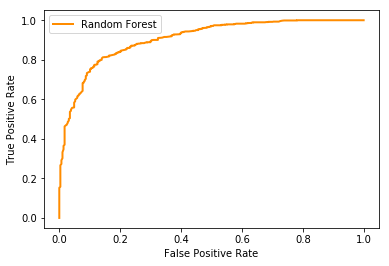

In [62]:
plt.figure()
plt.plot(rf_fpr,rf_tpr,color='darkorange',lw=2, label='Random Forest')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [78]:
alnizr_pred = clf.predict_proba(tri_alnizr[features])
write_for_plotting(tri_alnizr,alnizr_pred,'data/alnizr_pred_RF.csv',['Al','Ni','Zr'])

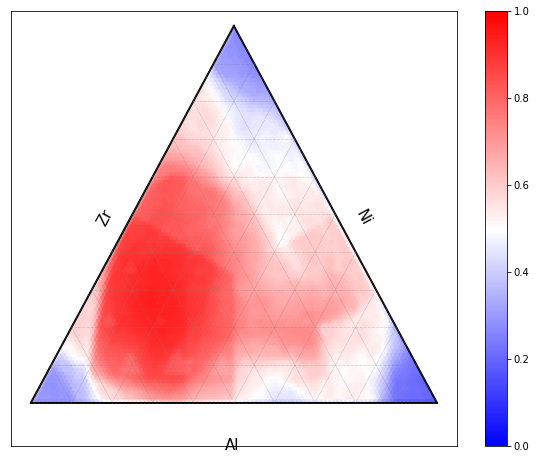

In [89]:
plot_ternary_data('data/alnizr_pred_RF.csv','plots/alnizr_pred_RF.png',False)

#### Learning Curve

In [114]:
features = imp_feat
train_sizes = []
train_scores = []
test_scores = []
for subset in [.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]:
    clf = RandomForestClassifier(n_estimators=500,n_jobs=-1,oob_score=True)
    train_subset = train[np.random.uniform(0,1,len(train))<=subset]
    clf.fit(train_subset[features],train_subset['Class'].astype(int))
    
    train_sizes.append(len(train_subset))

    train_ll, test_ll = compute_log_loss(clf, train, test, features)
    train_scores.append(train_ll)
    test_scores.append(test_ll)
    
    del train_subset
    del clf
# plt.plot(train_sizes,train_scores,'b-')
# plt.plot(train_sizes,test_scores,'r-')
# plt.xlabel('# of training samples')
# plt.ylabel('Log Loss')
# plt.legend(['Training set','Test set'])
# plt.savefig('plots/RF_learning curve')
# plt.show()

=======================
### Logistic Regression


Building Logistic Regression classifier......... Done.
Logistic Regression classifier generated 1 misclassifications out of 1151 resulting in 0.000869 classification error.
Logisitic Regression classifier test set AUROC: 0.8157786488579171
Logistic Regression classifier training set AUROC: 0.8823373061722666
Logistic Regression classifier test log-loss: 0.45370414700019396
Logistic Regression classifier train log-loss: 0.38631389731283494
Logistic Regression classifier F1 score: 0.7054263565891473


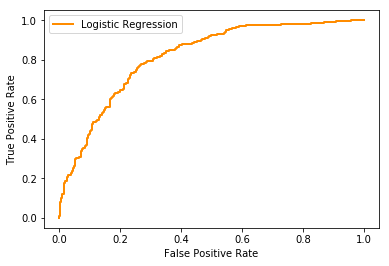

In [95]:
######   Logistic regression   ######
sys.stdout.write('\nBuilding Logistic Regression classifier......... ')
# Create classifier
clf = LogisticRegression()
# Train classifier on training data
clf.fit(train[features],y)
print('Done.')

# Predict classifications of test data
test_pred = clf.predict(train[features])
# Create vector with validation values of test data
test_val = test['Class'].astype(int).values
# Output the number of incorrect classifications
print('Logistic Regression classifier generated {:d} misclassifications out of {:d} resulting in {:f} classification error.'.format(np.sum(test_pred != test_val),len(test_val),np.sum(test_pred != test_val)/len(test_val)))

# Output the ROC curve and log-loss
test_proba = clf.predict_proba(test[features])
train_proba = clf.predict_proba(train[features])
train_proba1 = [x[0] for x in train_proba]
train_val = train['Class'].astype(int).values
test_proba1 = [x[0] for x in test_proba]
auroc = 1-roc_auc_score(test_val, test_proba1)
fpr_LR, tpr_LR, _ = metrics.roc_curve(test_val, test_proba1, pos_label=0)
fpr2, tpr2, _ = metrics.roc_curve(train_val, train_proba1, pos_label=0)
auroc2 = 1-roc_auc_score(train_val, train_proba1)
print('Logisitic Regression classifier test set AUROC:',auroc)
print('Logistic Regression classifier training set AUROC:',auroc2)

plt.plot(fpr_LR,tpr_LR,color='darkorange',lw=2,label='Logistic Regression')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('Logistic Regression classifier test log-loss:',metrics.log_loss(test_val,test_proba))
print('Logistic Regression classifier train log-loss:',metrics.log_loss(train_val,train_proba))
print('Logistic Regression classifier F1 score:',metrics.f1_score(y,test_pred))

alnizr_pred = clf.predict_proba(tri_alnizr[features])
write_for_plotting(tri_alnizr,alnizr_pred,'data/alnizr_pred_LG.csv',['Al','Ni','Zr'])

=======================
### SVM


Building Support Vector Machine classifier......... Done.
Support Vector Machine classifier generated 1 misclassifications out of 1151 resulting in 0.000869 classification error.
Logistic Regression classifier test set AUROC: 0.838333978577881
Logistic Regression classifier training set AUROC: 0.9094686038874655
Support Vector Machine classifier test log-loss: 0.41521954545237283
Support Vector Machine classifier train log-loss: 0.354572073985897
Support Vector Machine classifier F1 score: 0.7094133697135061


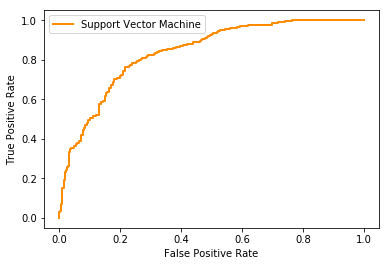

In [97]:
######   Support Vector Machine   ######
sys.stdout.write('\nBuilding Support Vector Machine classifier......... ')
# Create classifier
clf = SVC(probability=True)
# Train classifier on training data
clf.fit(train[features],y)
print('Done.')

# Predict classifications of test data
test_pred = clf.predict(train[features])
# Create vector with validation values of test data
test_val = test['Class'].astype(int).values
# Output the number of incorrect classifications
print('Support Vector Machine classifier generated {:d} misclassifications out of {:d} resulting in {:f} classification error.'.format(np.sum(test_pred != test_val),len(test_val),np.sum(test_pred != test_val)/len(test_val)))

# Output the ROC curve and log-loss
test_proba = clf.predict_proba(test[features])
train_proba = clf.predict_proba(train[features])
train_proba1 = [x[0] for x in train_proba]
train_val = train['Class'].astype(int).values
test_proba1 = [x[0] for x in test_proba]
auroc = 1-roc_auc_score(test_val, test_proba1)
fpr_SVM, tpr_SVM, _ = metrics.roc_curve(test_val, test_proba1, pos_label=0)
fpr2, tpr2, _ = metrics.roc_curve(train_val, train_proba1, pos_label=0)
auroc2 = 1-roc_auc_score(train_val, train_proba1)
print('Logistic Regression classifier test set AUROC:',auroc)
print('Logistic Regression classifier training set AUROC:',auroc2)

plt.plot(fpr_SVM,tpr_SVM,color='darkorange',lw=2,label='Support Vector Machine')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('Support Vector Machine classifier test log-loss:',metrics.log_loss(test_val,test_proba))
print('Support Vector Machine classifier train log-loss:',metrics.log_loss(train_val,train_proba))
print('Support Vector Machine classifier F1 score:',metrics.f1_score(y,test_pred))

alnizr_pred = clf.predict_proba(tri_alnizr[features])
write_for_plotting(tri_alnizr,alnizr_pred,'data/alnizr_pred_SVM.csv',['Al','Ni','Zr'])

=======================
### Simple Neural Net


Building Neural Network classifier......... Done.
Neural Network classifier generated 1 misclassifications out of 1151 resulting in 0.000869 classification error.
Neural Network classifier test set AUROC: 0.8733989869660601
Neural Network classifier training set AUROC: 0.9826749456515528


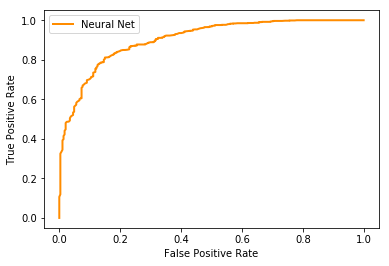

Neural Network classifier test log-loss: 0.5015375172906907
Neural Network classifier train log-loss: 0.16398063827453635
Neural Network classifier F1 score: 0.8892455858747994


In [99]:
######   Neural Network   ######
sys.stdout.write('\nBuilding Neural Network classifier......... ')
# Create classifier
clf = MLPClassifier(max_iter=500)
# Train classifier on training data
clf.fit(train[features],y)
print('Done.')

# Predict classifications of test data
test_pred = clf.predict(train[features])
# Create vector with validation values of test data
test_val = test['Class'].astype(int).values
# Output the number of incorrect classifications
print('Neural Network classifier generated {:d} misclassifications out of {:d} resulting in {:f} classification error.'.format(np.sum(test_pred != test_val),len(test_val),np.sum(test_pred != test_val)/len(test_val)))

# Output the ROC curve and log-loss
test_proba = clf.predict_proba(test[features])
train_proba = clf.predict_proba(train[features])
train_proba1 = [x[0] for x in train_proba]
train_val = train['Class'].astype(int).values
test_proba1 = [x[0] for x in test_proba]
auroc = 1-roc_auc_score(test_val, test_proba1)
fpr_NN, tpr_NN, _ = metrics.roc_curve(test_val, test_proba1, pos_label=0)
fpr2, tpr2, _ = metrics.roc_curve(train_val, train_proba1, pos_label=0)
auroc2 = 1-roc_auc_score(train_val, train_proba1)
print('Neural Network classifier test set AUROC:',auroc)
print('Neural Network classifier training set AUROC:',auroc2)
print('Neural Network classifier test log-loss:',metrics.log_loss(test_val,test_proba))
print('Neural Network classifier train log-loss:',metrics.log_loss(train_val,train_proba))
print('Neural Network classifier F1 score:',metrics.f1_score(y,test_pred))


plt.plot(fpr,tpr,color='darkorange',lw=2,label="Neural Net")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

alnizr_pred = clf.predict_proba(tri_alnizr[features])
write_for_plotting(tri_alnizr,alnizr_pred,'data/alnizr_pred_NN.csv',['Al','Ni','Zr'])

=======================
### Compare AUROC

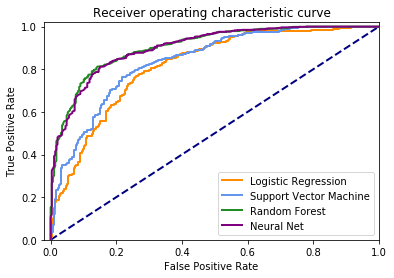

In [101]:
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr_LR,tpr_LR,color='darkorange',lw=2,label='Logistic Regression')
plt.plot(fpr_SVM,tpr_SVM,color='cornflowerblue',lw=2,label='Support Vector Machine')
plt.plot(rf_fpr,rf_tpr,color='forestgreen',lw=2, label='Random Forest')
plt.plot(fpr,tpr,color='purple',lw=2,label="Neural Net")
plt.legend()

plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.savefig('plots/roc_compare.pdf')

=======================
### Load high throughput data

In [125]:
######   Lodd high-throughput data   ######
allfeatures = list(data)
hitp_data = load_prep_data('../data/hitp_glass_data_featurized.csv',allfeatures)
hitp_train_data = hitp_data[~hitp_data['ternary_name'].isin(['Co-Fe-Zr','Co-V-Zr','Fe-Nb-Ti'])]
hitp_train_data = hitp_train_data.reset_index()
hitp_data.head()


,Si,Ti,V,Cr,Fe,Co,Ni,Zr,Nb,NComp,...,Ho,Er,Hf,Ta,W,Ir,Pt,Au,Pb,U
0,0.0646,0.0475,0.0,0.0,0.0,0.0,0.8878,0.0,0.000,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0555,0.0481,0.0,0.0,0.0,0.0,0.8965,0.0,0.000,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0000,0.0483,0.0,0.0,0.0,0.0,0.3777,0.0,0.574,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0743,0.0499,0.0,0.0,0.0,0.0,0.8759,0.0,0.000,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0638,0.0505,0.0,0.0,0.0,0.0,0.8857,0.0,0.000,0.0,...,0,0,0,0,0,0,0,0,0,0


=======================
### Plot high throughput data

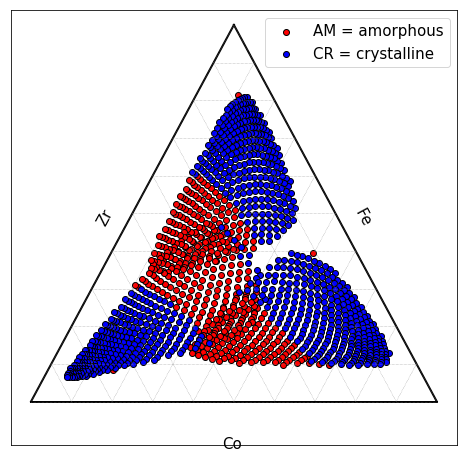

In [118]:
plot_ternary_data('data/cofezr_exp.csv','plots/cofezr_exp.png',True)

=======================
### Downsampling curve high throughput data

In [138]:
def learning_curve_HTP(LBtrain,HTPtrain,test,HTPtest,filename,do_plot=True):
    ######   Plot learning curve   ######
    # features = imp_feat
    train_sizes = []
    train_scores = []
    train_err = []
    test_scores = []
    test_err = []
    HTPtest_scores = []
    # subset_size = [0,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
    subset_size = [0,0.0001,0.001,0.005, 0.01,0.02,0.03, 0.05,0.075, 0.1,0.15,0.2,0.3, 0.5,0.75, 1]
    # subset_size = [0,0.001,0.005, 0.01, 0.1, 1]
    for subset in subset_size:
        # print('Training subset size: {}'.format(subset))
        
        HTPtrain_subset = HTPtrain[np.random.uniform(0,1,len(HTPtrain))<=subset]
        HTPtrain_size = len(HTPtrain_subset)
        train_sizes.append(len(HTPtrain_subset))
        print('Training subset size: {}% = {}'.format(subset*100,HTPtrain_size))

        train_subset = pd.concat([LBtrain, HTPtrain_subset])

        clf = RandomForestClassifier(n_estimators=500,n_jobs=-1,oob_score=True)
#         clf = MLPClassifier(activation='logistic', max_iter = 500)
        clf.fit(train_subset[features],train_subset['Class'].astype(int))

        test_val = test['Class'].astype(int).values
        test_proba = clf.predict_proba(test[features])
        test_ll = metrics.log_loss(test_val,test_proba[:,1])
        test_scores.append(test_ll)

        HTPtest_val = HTPtest['Class'].astype(int).values
        HTPtest_proba = clf.predict_proba(HTPtest[features])
        HTPtest_ll = metrics.log_loss(HTPtest_val,HTPtest_proba[:,1])
        HTPtest_scores.append(HTPtest_ll)

        train_val = LBtrain['Class'].astype(int).values
        train_proba = clf.predict_proba(LBtrain[features])
        train_ll = metrics.log_loss(train_val,train_proba[:,1])
        train_scores.append(train_ll)

        # train_scores.append(clf.oob_score_)
        # test_pred = clf.predict(test[features])
        # test_scores.append(clf.score(test[features],test_val))
        del train_subset
        del clf


    if do_plot:
        plot_learning_curve_HTP(filename, subset_size,train_scores,test_scores,HTPtest_scores, log = True)
    

    return subset_size,train_scores,test_scores, list(HTPtest_scores)

In [150]:
def plot_learning_curve_HTP(filename, subset_size,train_scores,test_scores,HTPtest_scores, log = True):
    if log:
        plt.semilogx(np.multiply(100,subset_size),train_scores,'b',linestyle='--', marker='o')
        plt.semilogx(np.multiply(100,subset_size),test_scores,'r',linestyle='--', marker='o')
        plt.semilogx(np.multiply(100,subset_size),HTPtest_scores,'g',linestyle='--', marker='o')
        plt.xlabel('% of HTP data')
        plt.ylabel('Log loss')
        plt.legend(['Training set','Test set','HTP Test set'])
        plt.savefig(filename)
        plt.show()
    else:
        plt.plot(np.multiply(100,subset_size),train_scores,'b',linestyle='--', marker='o')
        plt.plot(np.multiply(100,subset_size),test_scores,'r',linestyle='--', marker='o')
        plt.plot(np.multiply(100,subset_size),HTPtest_scores,'g',linestyle='--', marker='o')
        plt.xlabel('% of HTP data')
        plt.ylabel('Log loss')
        plt.legend(['Training set','Test set','HTP Test set'])
        plt.savefig(filename)
        plt.show()
    return plt

In [140]:
hitp_train_data = hitp_data[~hitp_data['ternary_name'].isin(['Co-Fe-Zr','Co-V-Zr','Fe-Nb-Ti'])]
hitp_test_data = hitp_data[hitp_data['ternary_name'].isin(['Co-Fe-Zr','Co-V-Zr','Fe-Nb-Ti'])]
# select every nth row from the high throughput training data
# n = 2
hitp_train_data = hitp_train_data.reset_index()
hitp_test_data = hitp_test_data.reset_index()

train, test, y = split_test_train(data,ternaries,.1,False)

filename = 'plots/Learning_curve_withHTP_log.png'
subset_size,train_scores,test_scores,HTPtest_scores = plot_learning_curve_HTP(train,hitp_train_data,test,hitp_test_data,filename,do_plot=False)

Number of observations in the training data: 4800
Number of observations in the test data: 569
Training subset size: 0% = 0
Training subset size: 0.01% = 1
Training subset size: 0.1% = 10
Training subset size: 0.5% = 37
Training subset size: 1.0% = 74
Training subset size: 2.0% = 144
Training subset size: 3.0% = 237
Training subset size: 5.0% = 373
Training subset size: 7.5% = 617
Training subset size: 10.0% = 731
Training subset size: 15.0% = 1143
Training subset size: 20.0% = 1509
Training subset size: 30.0% = 2306
Training subset size: 50.0% = 3701
Training subset size: 75.0% = 5532
Training subset size: 100% = 7497


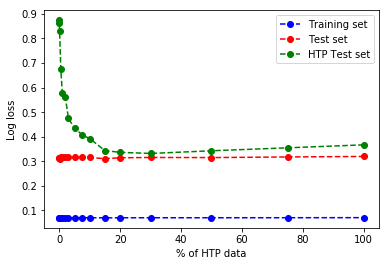

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [153]:
# linear plot
filename = 'plots/Learning_curve_withHTP_lin.png'
plot_learning_curve_HTP(filename, subset_size,train_scores,test_scores,HTPtest_scores, log = False)

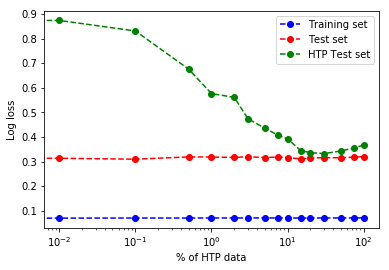

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [151]:
# log plot
filename = 'plots/Learning_curve_withHTP_log.png'
plot_learning_curve_HTP(filename, subset_size,train_scores,test_scores,HTPtest_scores, log = True)